<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the required libraries


In [ ]:
!pip install yfinance

In [ ]:
import math
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
from datetime import date, timedelta, datetime
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import export_text
from sklearn import tree, datasets
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [ ]:
symbol = "EURUSD=x"
start = datetime(2020, 3, 12)
end = datetime.now() - timedelta(days=7)
df = yf.download(tickers=symbol, start=start, end=end, interval="1h")
df.tail()
#mpf.plot(df,type='candle',mav=(3,6,9),volume=True)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2022-02-15 16:00:00+00:00,1.135847,1.137398,1.135847,1.136751,1.136751,0
2022-02-15 17:00:00+00:00,1.136622,1.136622,1.134945,1.136235,1.136235,0
2022-02-15 18:00:00+00:00,1.136235,1.137010,1.135976,1.135976,1.135976,0
2022-02-15 19:00:00+00:00,1.135847,1.136880,1.135847,1.136235,1.136235,0
2022-02-15 20:00:00+00:00,1.136622,1.137010,1.135976,1.136105,1.136105,0


# Data Extraction

In [ ]:
if 'Time' in df.columns:
  df['Date'] = df['Time']
  df.drop('Time', axis=1, inplace=True)
elif 'datetime' in df.columns:
  df['Date'] = df['datetime']
  df.drop('datetime', axis=1, inplace=True)
# capitalize the first letter in columns (if necessary)
df.columns = pd.Series(df.columns.str.capitalize())
df = df[df.index.dayofweek < 5]
# drop unamed (if it exists)
dropUnamed = True if 'Unnamed: 0' in df.columns else False # if the dataset contains unamed column
if dropUnamed:
  df.drop('Unnamed: 0', axis=1, inplace=True)
# drop before drop_before
df.head()
# drop volume
df.drop('Volume', axis=1, inplace=True)

# Add RSI, MACD indicators to df

In [ ]:
# constants
period = 14
macd_slow = 26*8
macd_fast = 12*8
macd_smooth = 9*8
rsi_period = 14

def get_macd(df, slow, fast, smooth):
    exp1_8 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow, adjust = False).mean()
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna(0)
    df['rsi'] = rsi_df[3:]
    return df

In [ ]:
df = get_macd(df, macd_slow, macd_fast, macd_smooth)
df = get_rsi(df, rsi_period)

In [ ]:
# Plot indicators
def plot_indicators(prices, df):
    ax_price = plt.subplot2grid((6,1), (0,0),  colspan = 1)
    ax_macd8 = plt.subplot2grid((6,1), (2,0), colspan = 1)
    ax_rsi = plt.subplot2grid((6,1), (4,0), colspan = 1)
    ax_volume = plt.subplot2grid((6,1), (5,0), colspan = 1)
    # plot the prices
    ax_price.plot(prices)
    # plot the indicators
    ax_macd8.plot(df['macd8'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax_macd8.plot(df['signal8'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
    ax_rsi.plot(df['rsi'], color = 'green', linewidth = 1.5, label = 'RSI')
    ax_volume.bar(prices.index, df['Volume'], color = 'grey', label = 'VOLUME')

    for i in range(len(prices)):
        if str(df['hist8'][i])[0] == '-':
            ax_macd8.bar(prices.index[i], df['hist8'][i], color = '#ef5350')
        else:
            ax_macd8.bar(prices.index[i], df['hist8'][i], color = '#26a69a')

    plt.legend(loc = 'lower right')

# Calculate max profit on each point and determine potential entry points



## Training and Validation Datasets

In [ ]:
# Standard Deviation 
df['Change'] = (df['Close']-df['Close'].shift(-1))/df['Close'].shift(-1)
# compute the risk (std) and the target rate
risk = df['Change'].std(skipna=True)
df.drop('Change', axis = 1, inplace=True)
# Define risk reward ratio
risk_factor = 4
target_rate = risk*risk_factor
print(target_rate)

0.0035951580393688534


In [ ]:
df.tail()

,Open,High,Low,Close,Adj close,macd8,signal8,hist8,rsi
2022-02-15 16:00:00+00:00,1.135847,1.137398,1.135847,1.136751,1.136751,-0.000479,0.001250,-0.001729,60.860607
2022-02-15 17:00:00+00:00,1.136622,1.136622,1.134945,1.136235,1.136235,-0.000476,0.001203,-0.001679,58.655516
2022-02-15 18:00:00+00:00,1.136235,1.137010,1.135976,1.135976,1.135976,-0.000476,0.001157,-0.001633,57.534094
2022-02-15 19:00:00+00:00,1.135847,1.136880,1.135847,1.136235,1.136235,-0.000473,0.001112,-0.001586,58.390805
2022-02-15 20:00:00+00:00,1.136622,1.137010,1.135976,1.136105,1.136105,-0.000472,0.001069,-0.001541,57.763037


In [ ]:
max_duration = 8 # in periods or laggs (for example 30min* 8 = 240min = 4 hours)
# get prices
highest_prices = df['Close']
lowest_prices = df['Close']
# calculte rolling min and max prices (after the possible entrypoints)
next_highest_prices = highest_prices.rolling(max_duration).max().shift(-max_duration)
next_lowest_prices = lowest_prices.rolling(max_duration).min().shift(-max_duration)
# Filter entrypoints before building the model
df['max_price'] = ((next_highest_prices - df['Close']) / df['Close'])
df['min_price'] = ((next_lowest_prices - df['Close']) / df['Close'])
# drop the last (max_duration) rows
df = df[:-max_duration]
# generate signals for the training dataset
# signal positive if the max price is above the target rate and the min price is above the risk 
df['tsignal'] = df.apply(lambda row: 1 if (row['max_price'] >= target_rate and row['min_price'] > -risk) else 0, axis =1)
df['atsignal'] = df.apply(lambda row: -1 if (row['min_price'] <= -target_rate and row['max_price'] < risk) else 0, axis =1)
df['tsignal'].loc[df.tsignal==0] = df.loc[df.tsignal==0]['atsignal']
# drop nans after replacing infinity
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [ ]:
# filter weak signals (insuffisant volume)
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


In [ ]:
# using scikitlearn to split the dataset into 80% training and 20% validation datasets 
feature_names = list(df.columns)
non_features = [ 'tsignal',  'min_price', 'max_price', 'Open', 'High', 'Low', 'atsignal', 'Adj close']
for nf in non_features:
  feature_names.remove(nf)
print(feature_names)

['Close', 'macd8', 'signal8', 'hist8', 'rsi']


In [ ]:
# train the model
X = df[feature_names]
y = df['tsignal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000)

rfc = RandomForestClassifier()

rfc = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('Model accuracy', accuracy_score(y_test, y_pred, normalize=True))
print(report)

Model accuracy 0.9028882377563834
              precision    recall  f1-score   support

          -1       0.86      0.39      0.54       189
           0       0.91      0.99      0.95      2045
           1       0.85      0.39      0.54       155

    accuracy                           0.90      2389
   macro avg       0.87      0.59      0.67      2389
weighted avg       0.90      0.90      0.89      2389



In [ ]:
X_test.head()

,Close,macd8,signal8,hist8,rsi
2021-12-14 05:00:00+00:00,1.128159,-0.000304,-0.000123,-0.000181,44.575611
2021-08-16 22:00:00+01:00,1.177995,-0.000988,-0.001920,0.000932,48.478239
2020-12-07 14:00:00+00:00,1.215362,0.006458,0.006176,0.000282,59.617328
2021-01-27 09:00:00+00:00,1.212562,-0.000156,-0.000577,0.000421,32.310863
2021-06-07 11:00:00+01:00,1.215953,-0.001203,-0.000481,-0.000722,48.978265


# Hyperparameter tuning using GridSearch

In [ ]:
"""
param_dict = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 10),
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 10)
}

grid = GridSearchCV(rfc, 
                    param_grid=param_dict,
                    cv = 3,
                    verbose = 1,
                    n_jobs = -1,
                    return_train_score=True)

grid.fit(X_train, y_train)
grid.best_estimator_
"""

'\nparam_dict = {\n    "criterion": [\'gini\', \'entropy\'],\n    "max_depth": range(1, 10),\n    "min_samples_split": range(1, 10),\n    "min_samples_leaf": range(1, 10)\n}\n\ngrid = GridSearchCV(rfc, \n                    param_grid=param_dict,\n                    cv = 3,\n                    verbose = 1,\n                    n_jobs = -1,\n                    return_train_score=True)\n\ngrid.fit(X_train, y_train)\ngrid.best_estimator_\n'

In [ ]:
from joblib import dump, load
dump(rfc, '/content/drive/MyDrive/data/FX{symbol}.joblib'.format(symbol=symbol.replace("=x", "").replace("=F", ""))) 

['/content/drive/MyDrive/data/FXEURUSD.joblib']

## Model feature importance
The mean decrease in Gini coefficient is a measure of how each variable contributes to the homogeneity of the nodes and leaves in the resulting random forest. The higher the value of mean decrease accuracy or mean decrease Gini score, the higher the importance of the variable in the model.

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 10))
#tree.plot_tree(rfc, fontsize=10)
#plt.show()

#Plot the signals

In [ ]:
ddf = df.drop(non_features, axis=1)
ddf['predicted_signal'] = rfc.predict(ddf) 
ddf['Close'] = df['Close']
# reduce data
ddf = ddf[-300:]

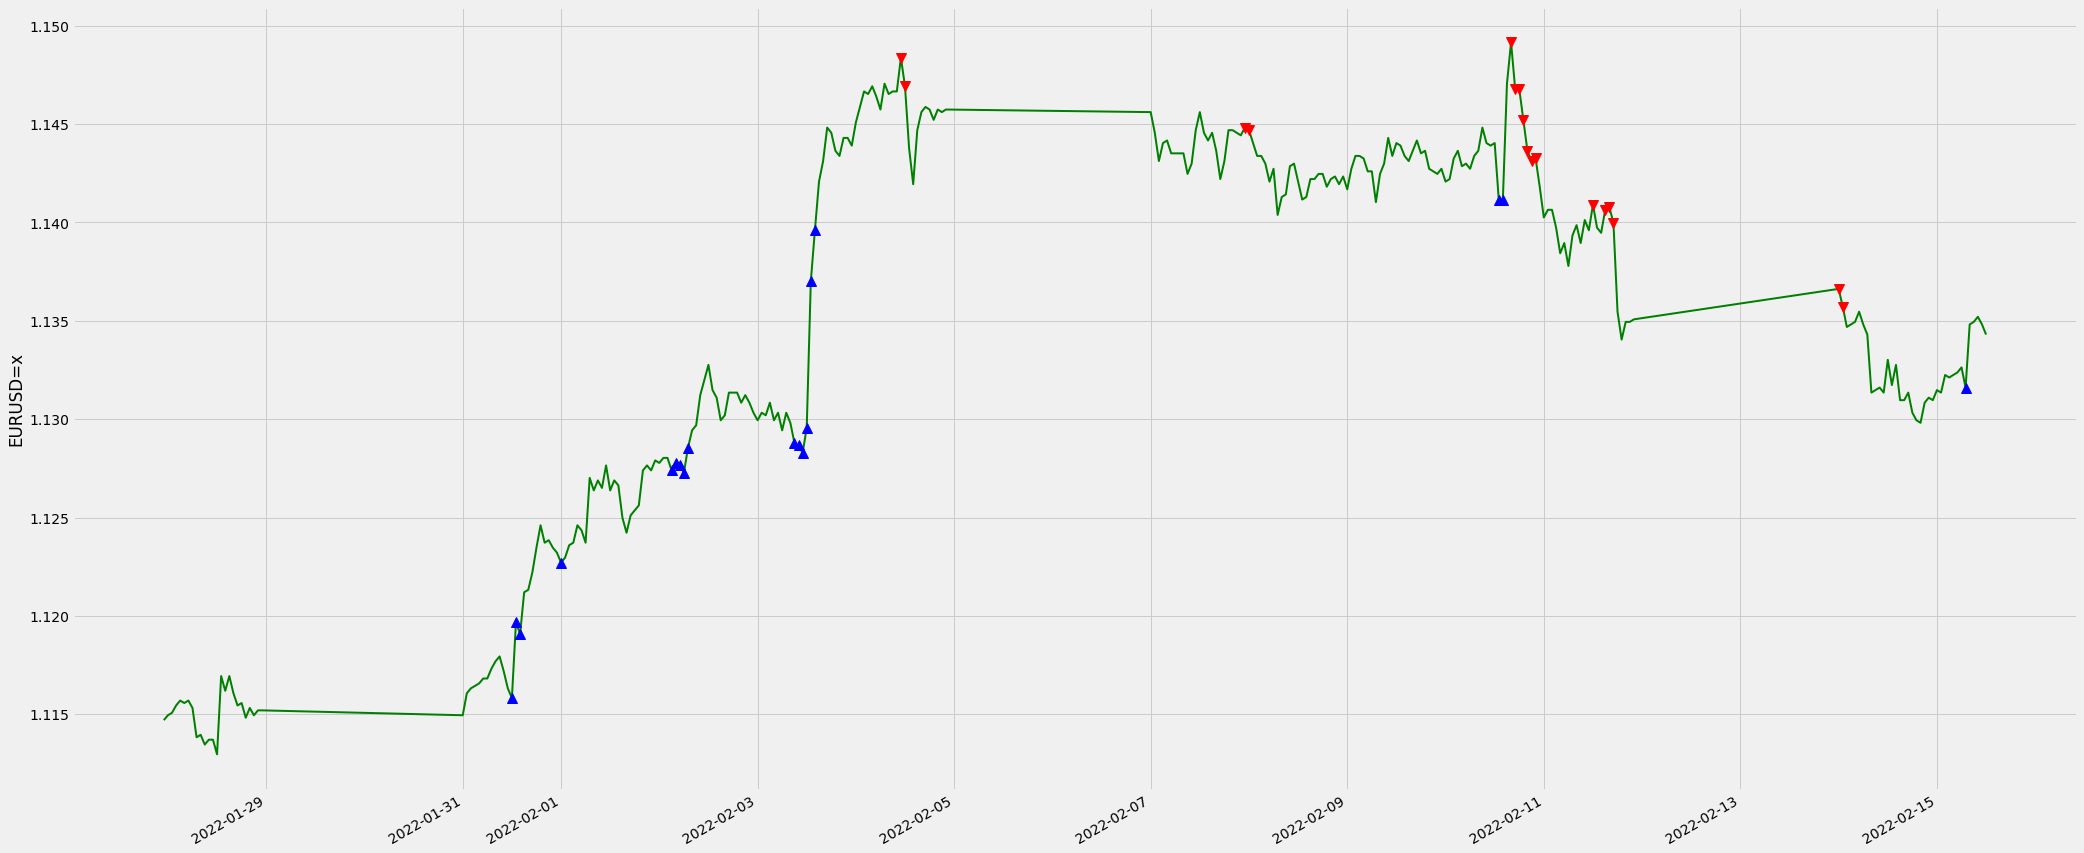

In [ ]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel=symbol)

## Plot the closing price
ddf['Close'].plot(ax=ax1, color='g', lw=2.)

# Plot the buy signals
ax1.plot(ddf.loc[ddf.predicted_signal == 1.0].index, 
         ddf.Close[ddf.predicted_signal == 1.0],
         '^', markersize=10, color='b')

# Plot the sell signals
ax1.plot(ddf.loc[ddf.predicted_signal == -1.0].index, 
         ddf.Close[ddf.predicted_signal == -1.0],
         'v', markersize=10, color='r')
# Show the plot
plt.show()

# Simple Backtest

                           EURUSD=x  holdings        cash   total   returns
2022-02-15 08:00:00+00:00       0.0       0.0  610.648489  610.65  0.055502
2022-02-15 09:00:00+00:00       0.0       0.0  610.648489  610.65  0.000000
2022-02-15 10:00:00+00:00       0.0       0.0  610.648489  610.65  0.000000
2022-02-15 11:00:00+00:00       0.0       0.0  610.648489  610.65  0.000000
2022-02-15 12:00:00+00:00       0.0       0.0  610.648489  610.65  0.000000


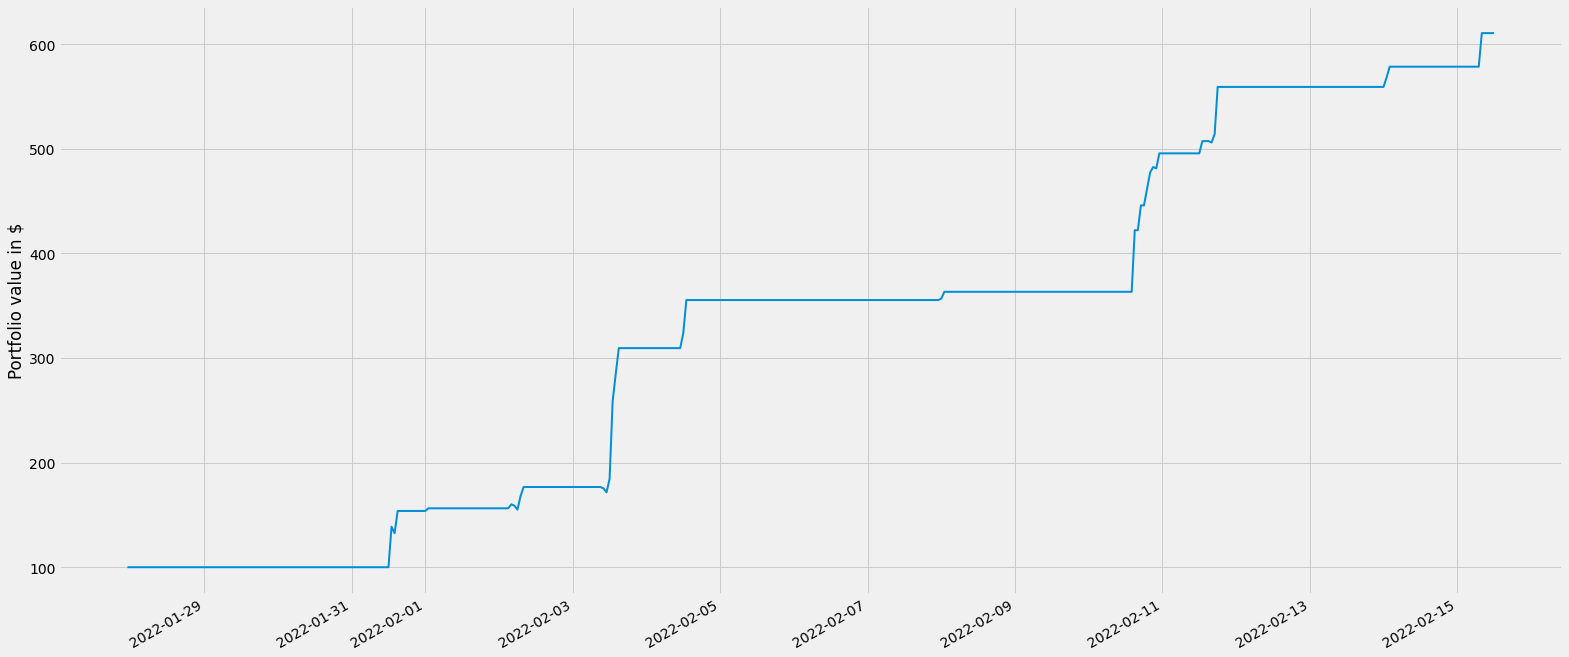

In [ ]:
# Set the initial capital
initial_capital= float(100.0)
lev = 100

# Create a DataFrame `positions`
positions = pd.DataFrame(index=ddf['predicted_signal'].index).fillna(0.0)

# Trade 
vol = lev * initial_capital
positions[symbol] = vol*ddf['predicted_signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ddf['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ddf['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(ddf['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = round(portfolio['cash'] + portfolio['holdings'], 2)

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio.total.plot(ax=ax1, lw=2.)

# Print the first lines of `portfolio`
print(portfolio.tail())

# Show the plot
plt.show()

#Market Scan and Test

In [ ]:
# Scan the last 72 signals
end = datetime.now()
start = end - timedelta(days=90)
target = yf.download(tickers=symbol, start=start, end=end, interval="1h")
target.columns = pd.Series(target.columns.str.capitalize())
target = target[target.index.dayofweek < 5]
target.drop('Volume', axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
target = get_macd(target, macd_slow, macd_fast, macd_smooth)
target = get_rsi(target, rsi_period)
target['tsignal'] = '0'
target['atsignal'] = '0'
target['min_price'] = '0'
target['max_price'] = '0'
target.replace([np.inf, -np.inf], np.nan, inplace=True)
target = target.dropna(0)

# Make prediction using our model

In [ ]:
target.drop(non_features, axis=1, inplace=True)
#reduce data
target = target[-200:]

In [ ]:
target['predicted_signal'] = rfc.predict(target) 
signals = target.loc[(target.predicted_signal == 1) | (target.predicted_signal ==-1)]
# display the latest signals and generate TP and SL points
signals['TP'] =  signals['Close'] + signals['predicted_signal'] *signals['Close'] * target_rate
signals['SL'] =  signals['Close'] - signals['predicted_signal'] *signals['Close'] * risk
signals.tail()

,Close,macd8,signal8,hist8,rsi,predicted_signal,TP,SL
2022-02-11 16:00:00+00:00,1.140771,0.002700,0.003539,-0.000838,49.075154,-1,1.136670,1.141796
2022-02-11 17:00:00+00:00,1.139991,0.002656,0.003515,-0.000858,46.002323,-1,1.135892,1.141016
2022-02-14 00:00:00+00:00,1.136622,0.002114,0.003331,-0.001217,41.653035,-1,1.132536,1.137644
2022-02-14 01:00:00+00:00,1.135718,0.002037,0.003295,-0.001258,39.043191,-1,1.131635,1.136739
2022-02-15 07:00:00+00:00,1.131606,-0.000361,0.001730,-0.002091,43.793607,1,1.135674,1.130589


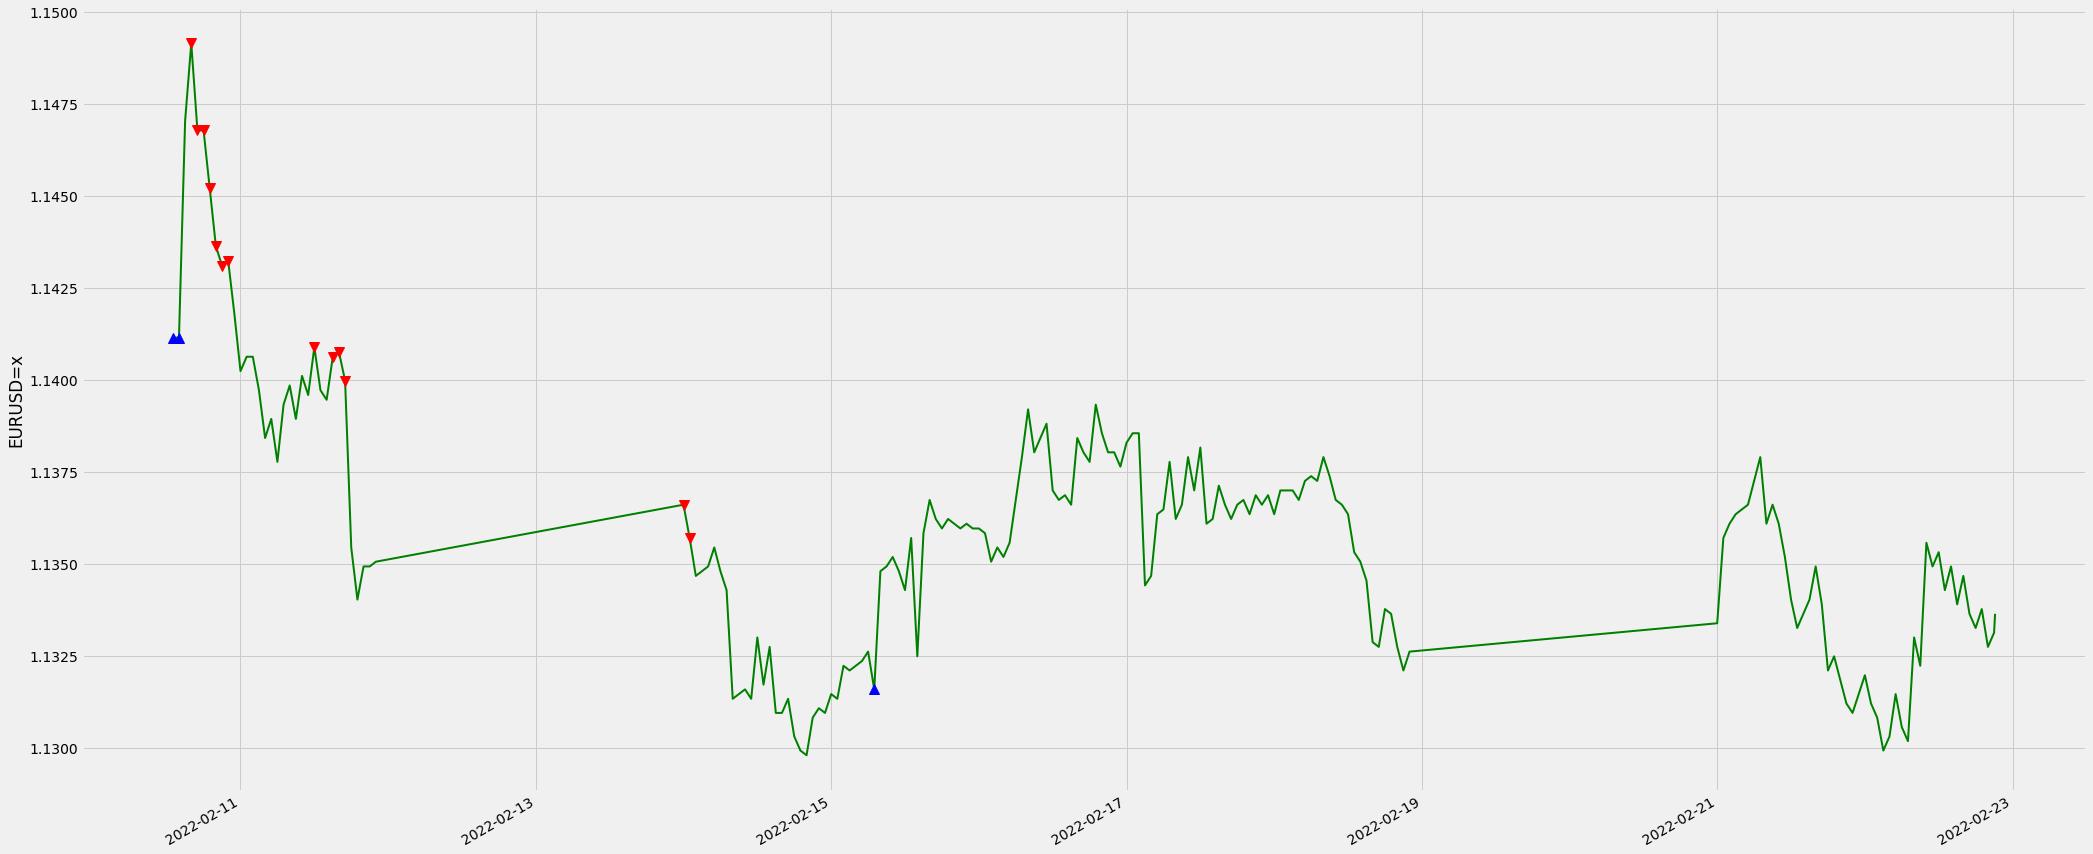

In [ ]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel=symbol)

## Plot the closing price
target['Close'].plot(ax=ax1, color='g', lw=2.)

# Plot the buy signals
ax1.plot(target.loc[target.predicted_signal == 1.0].index, 
         target.Close[target.predicted_signal == 1.0],
         '^', markersize=10, color='b')

# Plot the sell signals
ax1.plot(target.loc[target.predicted_signal == -1.0].index, 
         target.Close[target.predicted_signal == -1.0],
         'v', markersize=10, color='r')

# Show the plot
plt.show()
